In [1]:
import numpy as np
import scanpy as sp
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import sklearn as sk
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split

seed = 2023 # DO NOT CHANGE!

In [2]:
print(f"sklearn version: {sk.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"scanpy version: {sp.__version__}")

sklearn version: 1.0.1
numpy version: 1.21.3
pandas version: 1.3.4
matplotlib version: 3.4.3
scanpy version: 1.9.1


# Load Data

In [3]:
PBMC = sp.read_h5ad("../pbmc_multiome.h5ad")

In [4]:
print(f"The data has {PBMC.n_obs} observations and {PBMC.n_vars} features.")

The data has 9641 observations and 19607 features.


In [5]:
PBMC.X

<9641x19607 sparse matrix of type '<class 'numpy.float64'>'
	with 73296936 stored elements in Compressed Sparse Row format>

In [6]:
PBMC.obs['predicted.id']

AAACAGCCAACAACAA-1      CD4 TCM
AAACAGCCAAGGACCA-1    CD4 Naive
AAACAGCCACAATGCC-1      CD8 TEM
AAACAGCCATGAGCAG-1      CD4 TCM
AAACATGCAAGATTCT-1      CD4 TCM
                        ...    
TTTGTGGCATTAGGTT-1           NK
TTTGTGGCATTGCGTA-1      CD8 TEM
TTTGTGTTCAAGCGCC-1    CD4 Naive
TTTGTGTTCGTTTCCA-1    CD14 Mono
TTTGTTGGTACCCACC-1      CD4 TCM
Name: predicted.id, Length: 9641, dtype: object

9641 number of cells, with 27 total cell types


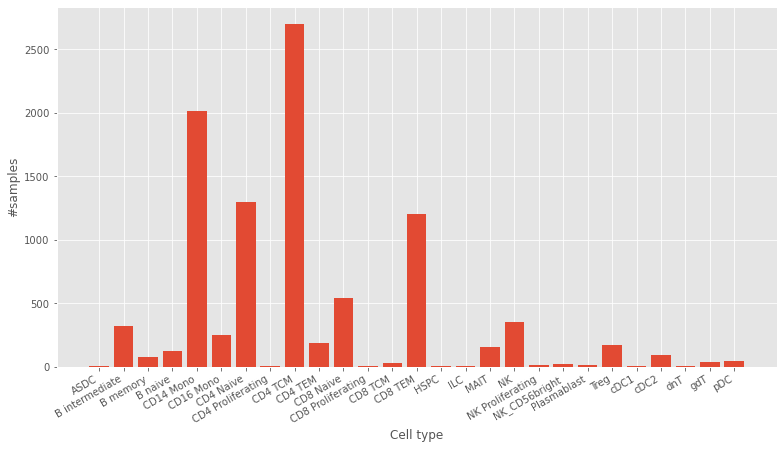

In [7]:
cell_types, type_numbers = np.unique(PBMC.obs['predicted.id'], return_counts=True)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
print(f"{np.sum(type_numbers)} number of cells, with {len(cell_types)} total cell types")
ax.bar(list(map(str, cell_types)), type_numbers)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Cell type")
plt.ylabel("#samples")
plt.show()

# Filtering + Train/Test Split

In [8]:
cutoff = 0.001
# Cut off

cell_types, type_numbers = np.unique(PBMC.obs['predicted.id'], return_counts=True)
bad_types = cell_types[type_numbers / len(PBMC.obs['predicted.id'])<cutoff]
print(bad_types)

bad_types_mask = np.invert(np.isin(PBMC.obs['predicted.id'], bad_types))
X = PBMC.X[bad_types_mask]
Y = PBMC.obs['predicted.id'][bad_types_mask]

print(Y.shape)

['ASDC' 'CD4 Proliferating' 'CD8 Proliferating' 'HSPC' 'ILC' 'cDC1' 'dnT']
(9619,)


9619 number of cells, with 20 total cell types


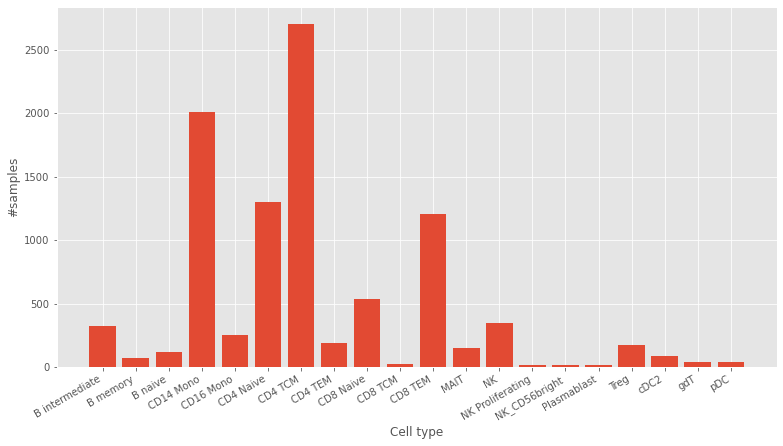

In [9]:
cell_types, type_numbers = np.unique(Y, return_counts=True)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
print(f"{np.sum(type_numbers)} number of cells, with {len(cell_types)} total cell types")
ax.bar(list(map(str, cell_types)), type_numbers)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Cell type")
plt.ylabel("#samples")
plt.show()

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=seed)

n_train = X_train.shape[0]
n_test = X_test.shape[0]
print(f"{n_train} train samples\n{n_test} test samples\n{n_train/(n_train+n_test)*100:.2f}% of samples used for training")

7214 train samples
2405 test samples
75.00% of samples used for training


# Model training

In [ ]:
n_folds = 5 # change?

cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state = seed)

param_grid = {
    'C': [10**x for x in np.arange(-5, 0.5, 0.5)]
}

lsvc = svm.LinearSVC()
gridsearch = GridSearchCV(lsvc, param_grid, n_jobs=-1, cv=cv, verbose=5, 
                          return_train_score=True)

gridsearch.fit(X_train, Y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END .......C=1e-05;, score=(train=0.775, test=0.687) total time=  31.1s
[CV 2/5] END .......C=1e-05;, score=(train=0.778, test=0.694) total time=  30.6s
[CV 3/5] END .......C=1e-05;, score=(train=0.772, test=0.696) total time=  31.0s
[CV 4/5] END .......C=1e-05;, score=(train=0.772, test=0.690) total time=  31.0s
[CV 5/5] END .......C=1e-05;, score=(train=0.776, test=0.691) total time=  31.0s


In [ ]:
results = gridsearch.cv_results_
train_score = results['mean_train_score'][gridsearch.best_index_]
validation_score = results['mean_test_score'][gridsearch.best_index_]

print(f'Average training accuracy across folds: {train_score:.3}')
print(f'Average validation accuracy across folds: {validation_score:.3}')

print(f'Best hyperparams: {gridsearch.best_params_}')

In [ ]:
# save best model
with open('PBMC_lsvm.pkl','wb') as f:
    pickle.dump(gridsearch.best_estimator_,f)